In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['strange and ridiculous to meet objections from russian generals and to',
 'clear bright expression as if asking them to notice how calmly he sat',
 '',
 'ages rostov leaning his head on both hands sat at the table which was',
 'match but a splendid noble fellow he is my friend',
 'one would have thought it impossible for a man to stretch himself more',
 'bursts of song and music and the inconsequent but friendly prattle of',
 '',
 'to weyrother sat count langeron who with a subtle smile that never left',
 'orders to admit no more but the porter was told to be sure to invite to']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.5264, -0.3015,  0.0597,  ...,  1.2156, -1.8306,  0.7555],
        [-1.0271,  0.3901, -1.1249,  ..., -0.3244, -0.3176,  0.1094],
        [ 0.2768, -0.9981,  2.0550,  ...,  0.4840,  1.1808,  0.3708],
        ...,
        [-1.2371, -0.1641,  1.6813,  ..., -0.6449,  0.3641, -1.6345],
        [ 0.6418,  0.3796, -1.8559,  ..., -0.9597, -0.8005, -0.0073],
        [-0.6577,  0.1265, -0.0029,  ...,  0.0413,  0.1539, -0.4011]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_31/64346145.py line 8 
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 05:29:28.807000 140417444616000 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/s

 catherine bluishgray snoring gazing cherish wooded done spending hubbub deacons priest clattering dismount votre intending hopes assure post betray austrian hark slippery touches quartette benediction coarsest themand tossed therethere nonreceipt ffflop uproar successfully fundamental himthe  painstaking loudest surroundings sharpshooters goal materials sit disagreed duelist streak ecstasy corpses elbow wifeperhaps dignitary manyand confirming shallowness new rainsoaked destroy revived majestic diplomatic civilianan prizing cleanshaven everythingthats thundered battalions octogenarians drowning advance atmosphere recognize marshalls sick witnessed warm stepped alter disjointed cow recommended jocular lifes displaying memoirs papa amiable laborerthats pearls activitythe littlebut trepidation saves officers slightest rare illegitimate nod toss theater furnished
 playful toss wrote campaign knee boiler une one presidents promener insisting conquest unimportance flanks major declaration s

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([512, 512])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

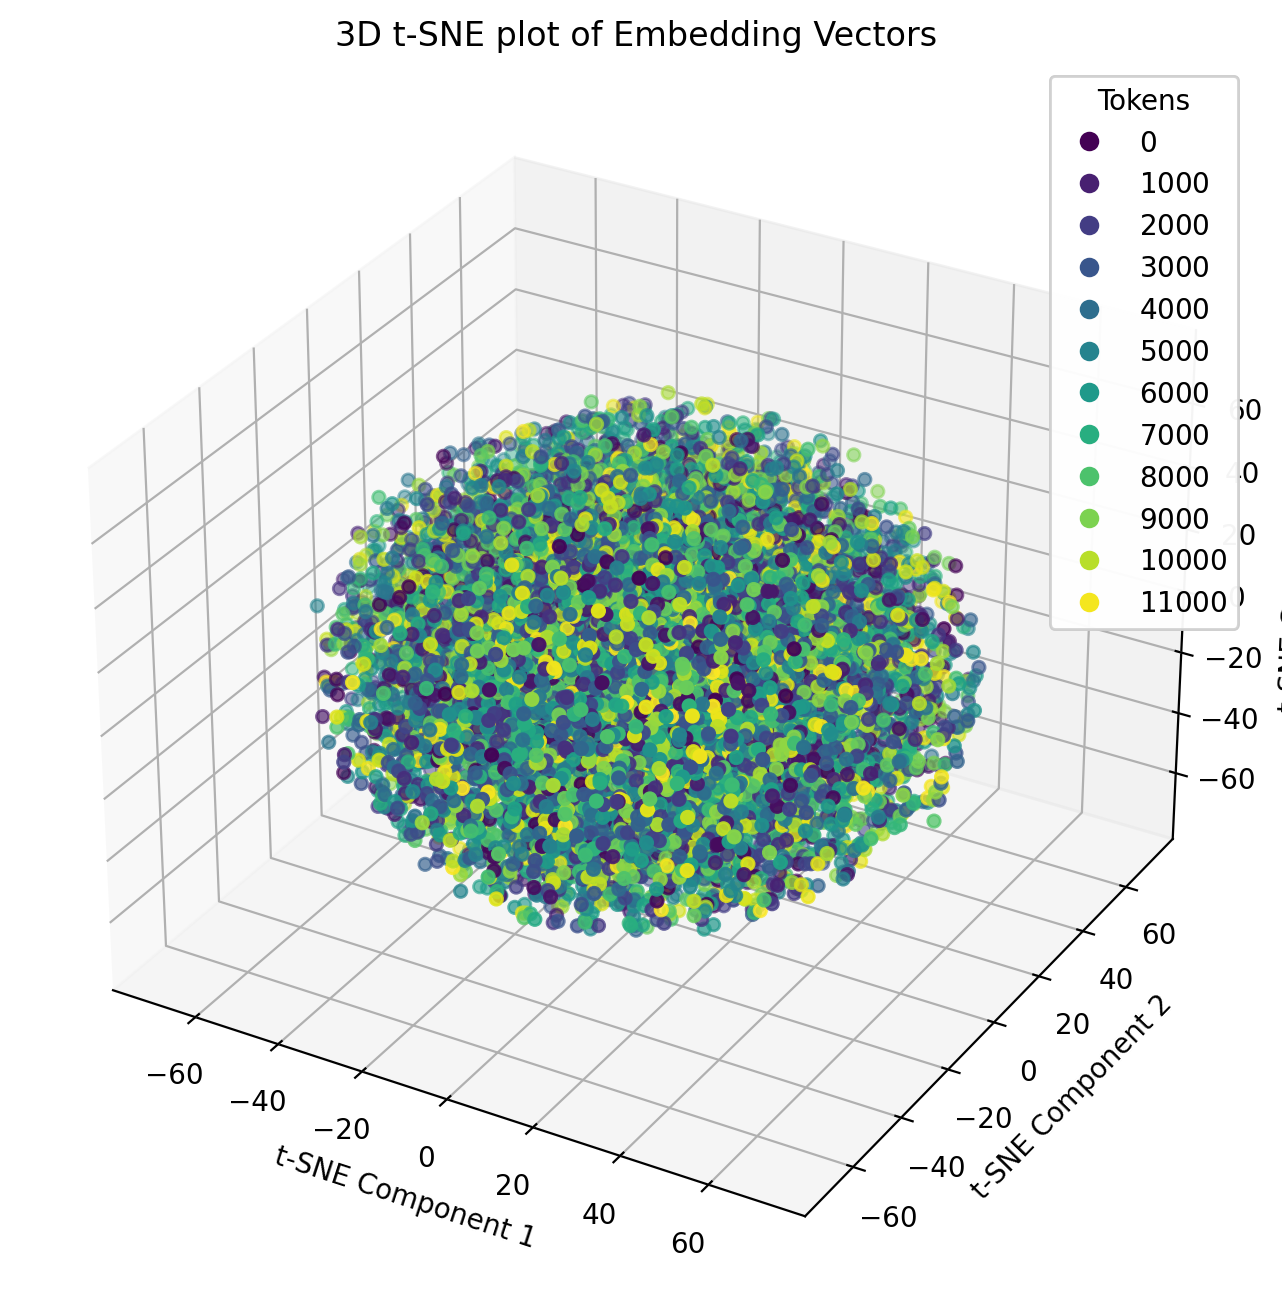

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [17]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 13.09732437133789
Epoch 10, Loss: 10.319357872009277
Epoch 20, Loss: 9.509149551391602
Epoch 30, Loss: 8.830772399902344
Epoch 40, Loss: 8.206554412841797
Epoch 50, Loss: 7.617336273193359
Epoch 60, Loss: 7.064035415649414
Epoch 70, Loss: 6.570967674255371
Epoch 80, Loss: 6.164675712585449
Epoch 90, Loss: 5.838029861450195
Epoch 100, Loss: 5.572754859924316
Epoch 110, Loss: 5.351481914520264
Epoch 120, Loss: 5.162452697753906
Epoch 130, Loss: 4.997725486755371
Epoch 140, Loss: 4.851163864135742
Epoch 150, Loss: 4.718301296234131
Epoch 160, Loss: 4.595638275146484
Epoch 170, Loss: 4.480936527252197
Epoch 180, Loss: 4.373171806335449
Epoch 190, Loss: 4.271275997161865
Epoch 200, Loss: 4.174530982971191
Epoch 210, Loss: 4.082853317260742
Epoch 220, Loss: 3.9958529472351074
Epoch 230, Loss: 3.913086414337158
Epoch 240, Loss: 3.8344132900238037
Epoch 250, Loss: 3.7595105171203613
Epoch 260, Loss: 3.687938690185547
Epoch 270, Loss: 3.619906187057495
Epoch 280, Loss: 3.55499887

In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 advice
 
 anna mikhaylovna and snatching others the emperors approach
 
 * you are you not only know boris saying muttered but those who were like
 the table continued when he had gone to do in something more he
 russia had sunk greatly themselves for the proprietor of
 emperor rang in the evening he heard one without them something
 mademoiselle bourienne at the people say but to be
 filled the courtiers and the last and thrusting the chapel ended and the princes face handsome


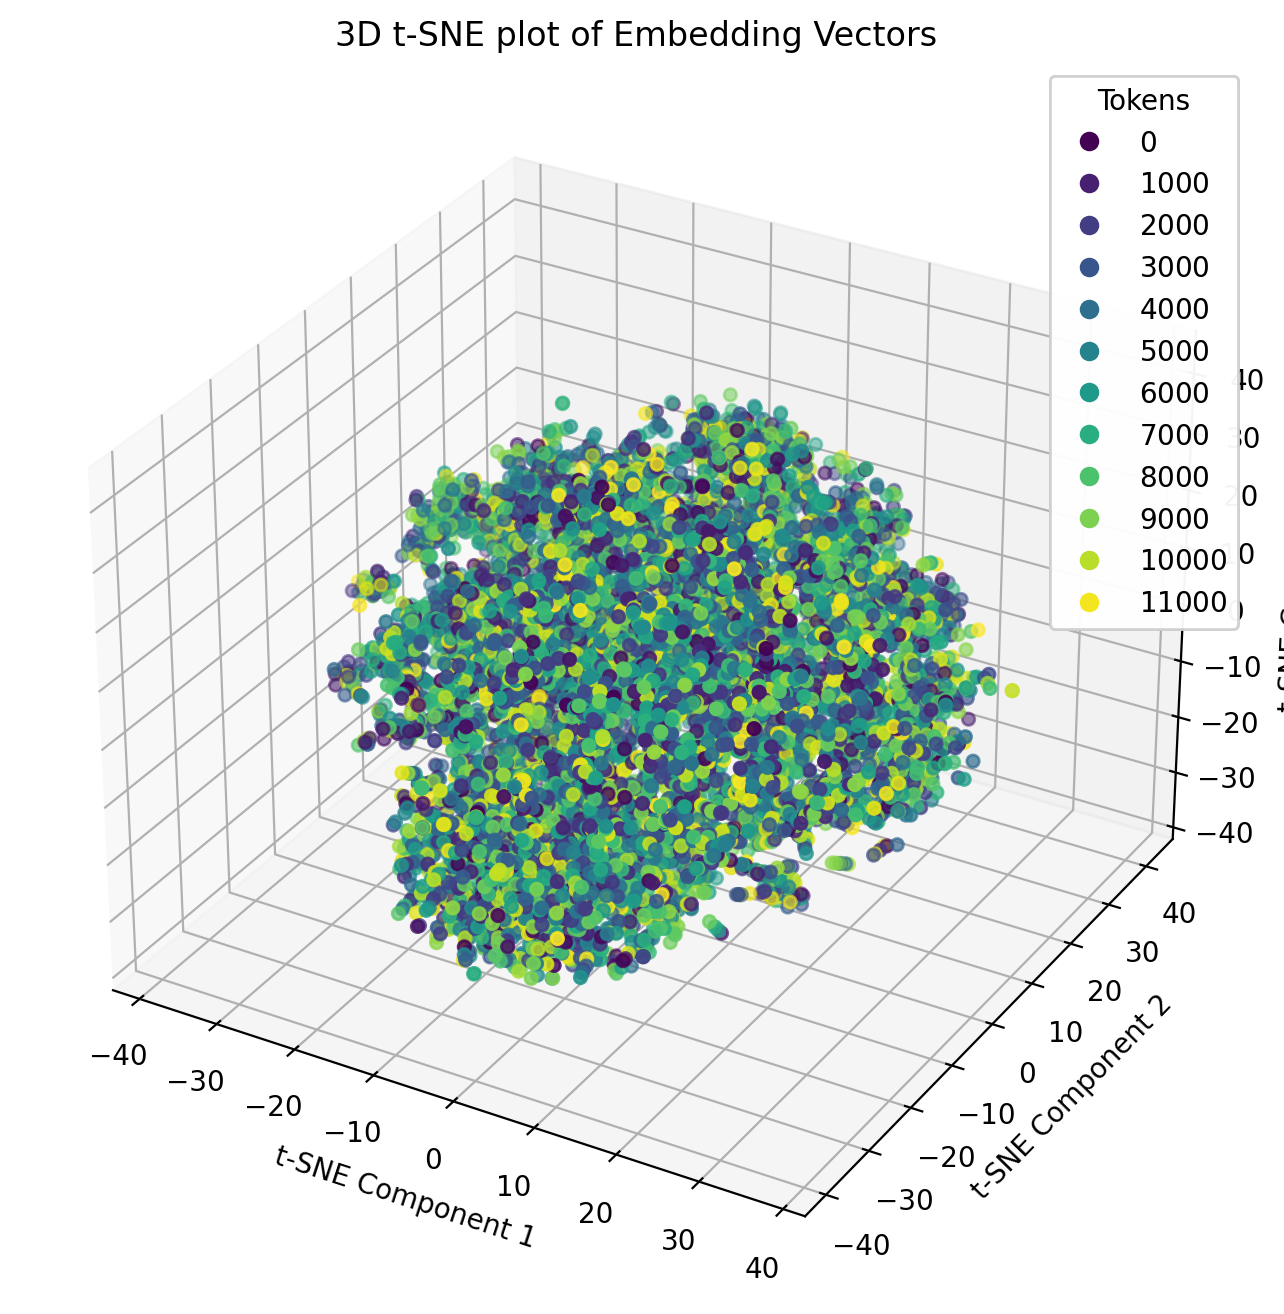

In [19]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [22]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_64_512_r.pth")

In [21]:
model = model.to(device)